# Theoretic CSR

In [10]:
import sys
sys.path.insert(0, '../../src/')

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd


#np.set_printoptions(threshold=sys.maxsize)
np.set_printoptions(precision=4)

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

## Read Raw Spectrum Data

In [11]:
def load_data(file_path):
    # Check if the file exists
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"The file {file_path} does not exist.")

    # Load the data using pandas
    data = pd.read_csv(file_path, delim_whitespace=True, header=None)
    
    # Convert the DataFrame to a NumPy array
    data_array = data.to_numpy()
    
    return data_array

import re
import numpy as np

# pre-compile the regex for performance
_exp_pat = re.compile(r'\*\^([+-]?\d+)')


def to_complex_array(obj_arr: np.ndarray) -> np.ndarray:
    """
    Convert an array of strings of the form
      - 'a+bi*I'
      - 'a-bi*I'
      - 'a*^b+ci*I'
      - 'a*^b-ci*I'
    into a numpy array of complex numbers.
    
    Parameters
    ----------
    obj_arr : np.ndarray
        Object-dtype (or string-dtype) array where each entry is a string
        like '0.5+1.2*I' or '-3.9*^-7-0.37*I'.
    
    Returns
    -------
    np.ndarray
        Array of dtype complex128 with the same shape as obj_arr.
    """
    str_arr = obj_arr.astype(str)
    
    def _convert_one(s: str) -> str:
        # 1) replace "*^b" → "eb"
        s = _exp_pat.sub(r'e\1', s)
        # 2) replace "*I" → "j"
        s = s.replace('*I', 'j')
        return s
    
    # vectorize across the array
    vect = np.vectorize(_convert_one, otypes=[str])
    j_arr = vect(str_arr)
    
    # finally cast to complex128
    return j_arr.astype(np.complex128)


## AI Infinite

C:\Users\krist\AppData\Local\Temp\ipykernel_27332\264601642.py:7: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(file_path, delim_whitespace=True, header=None)


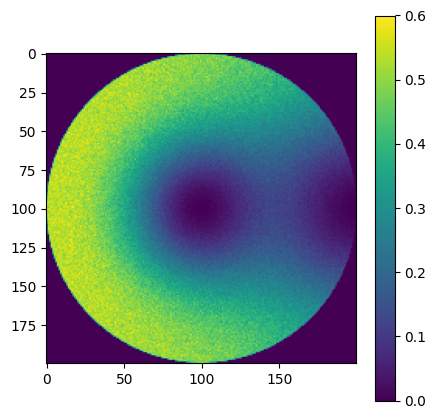

In [12]:
raw = load_data("data/histogram_csr_AI_inf.dat")
c_max = 0.6

dim2 = raw.shape[0]
dim = int(np.sqrt(dim2))

csr_density = raw[:,2].reshape(dim, dim).T
dA = 4/40000
norm = np.sum(csr_density)*dA
csr_density = csr_density/norm

fig = plt.figure(figsize=(5, 5))
fig.tight_layout()
plt.imshow(csr_density)
plt.clim(0, c_max)
plt.colorbar()
np.savetxt("book_keeping/figure1/hist_AIinf_theory.txt", csr_density)
plt.show()

## AI 4 +1

C:\Users\krist\AppData\Local\Temp\ipykernel_27332\264601642.py:7: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(file_path, delim_whitespace=True, header=None)


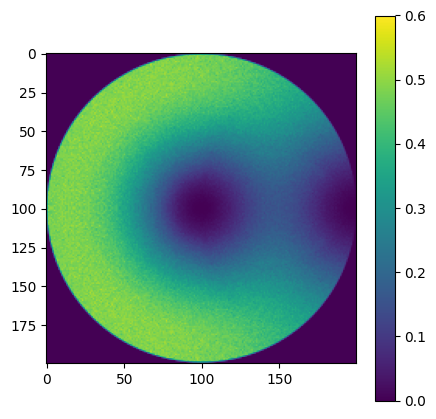

In [13]:
raw = load_data("data/histAI41.dat")
c_max = 0.6

dim2 = raw.shape[0]
dim = int(np.sqrt(dim2))

csr_density = raw[:,2].reshape(dim, dim).T
dA = 4/40000
norm = np.sum(csr_density)*dA
csr_density = csr_density/norm

fig = plt.figure(figsize=(5, 5))
fig.tight_layout()
plt.imshow(csr_density)
plt.clim(0, c_max)
plt.colorbar()
np.savetxt("book_keeping/figure1/hist_AI41_theory.txt", csr_density)
plt.show()

## FF Infinite

C:\Users\krist\AppData\Local\Temp\ipykernel_27332\264601642.py:7: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(file_path, delim_whitespace=True, header=None)


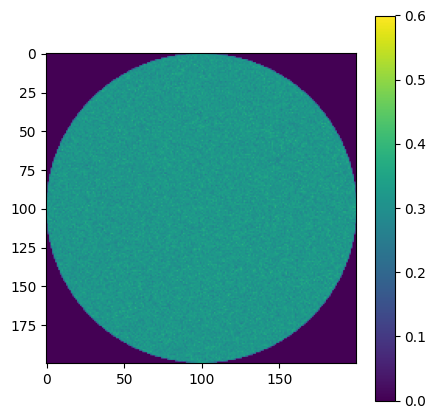

In [14]:
raw = load_data("data/histogram_csr_FF_inf.dat")
c_max = 0.6

dim2 = raw.shape[0]
dim = int(np.sqrt(dim2))

csr_density = raw[:,2].reshape(dim, dim).T
dA = 4/40000
norm = np.sum(csr_density)*dA
csr_density = csr_density/norm

bins = raw[:,0].reshape(dim, dim)

fig = plt.figure(figsize=(5, 5))
fig.tight_layout()
plt.imshow(csr_density)
plt.clim(0, c_max)
plt.colorbar()
np.savetxt("book_keeping/figure1/hist_FFinf_theory.txt", csr_density)
plt.show()

## FF 4+1

C:\Users\krist\AppData\Local\Temp\ipykernel_27332\264601642.py:7: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(file_path, delim_whitespace=True, header=None)


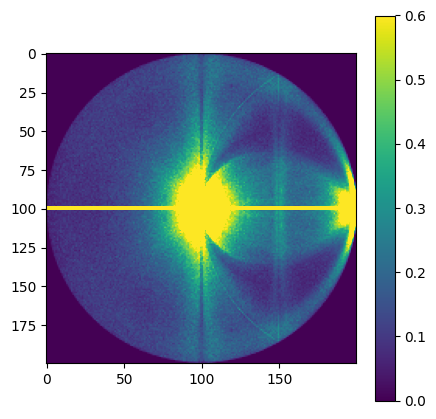

In [ ]:
raw = load_data("data/histFF41.dat")
c_max = 0.6

dim2 = raw.shape[0]
dim = int(np.sqrt(dim2))

csr_density = raw[:,2].reshape(dim, dim).T
dA = 4/40000
norm = np.sum(csr_density)*dA
csr_density = csr_density/norm

np.savetxt("book_keeping/hist_FF41_theory.txt", csr_density)

fig = plt.figure(figsize=(5, 5))
fig.tight_layout()
plt.imshow(csr_density)
plt.colorbar()
plt.clim(0, c_max)
plt.savefig('figures/FF_41.png')
plt.show()